# Analysing growth data using the Monod equation

Example for Sytems Biology for Scientific Computing: week three

# Problem

We have some tubes containing a substrate $S$ and some biomass $C$ that
we think approximately follow the Monod equation for microbial growth:

We measured $C$ and $S$ at different timepoints in some experiments and
we want to try and find out $\mu_{max}$, $K_{S}$ and $\gamma$ for the
different strains in the tubes.

You can read more about the Monod equation in Allen and Waclaw (2019).

# What we know

$\mu_{max}, K_S, \gamma, S, C$ are non-negative.

$S(0)$ and $C(0)$ vary a little by tube.

$\mu_{max}, K_S, \gamma$ vary by strain.

Measurement noise is roughly proportional to measured quantity.

# Statistical model

We use two regression models to describe the measurements:

To capture the variation in parameters by tube and strain we add a
hierarchical regression model:

To get a true abundance given some parameters we put an ode in the
model:

$$
\hat{C}(t), \hat{S}(t) = \text{solve-monod-equation}(t, C_0, S_0, \mu_max, \gamma, K_S)
$$

# Stan program

The statistical model described above is written down as a Stan program
at `monod.stan`.

Check it out!

The rest of the notebook uses this program to generate some simulated
measurements, then attempt to fit the simulated measurements.

# imports

In [1]:
import itertools

import arviz as az
import cmdstanpy
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

# Specify the problem

The next few code blocks define the problem using Python code.

In order to avoid doing too much annoying handling of strings we assume
that all the parts of the problem have meaningful 1-indexed integer
labels: for example, species 1 is biomass.

This code specifies the dimensions of our problem.

In [2]:
N_strain = 4
N_tube = 16
N_timepoint = 20
duration = 15
strains = [i+1 for i in range(N_strain)]
tubes = [i+1 for i in range(N_tube)]
species = [1, 2]
measurement_timepoint_ixs = [4, 7, 12, 15, 17]
timepoints = pd.Series(
    np.linspace(0.01, duration, N_timepoint),
    name="time",
    index=range(1, N_timepoint+1)
)

This code defines some prior distributions for the model’s parameters

In [3]:
priors = {
    # parameters that can be negative:
    "prior_a_mu_max": [-1.8, 0.2],
    "prior_a_ks": [-1.3, 0.1],
    "prior_a_gamma": [-0.5, 0.1],
    # parameters that are non-negative:
    "prior_t_mu_max": [-1.4, 0.1],
    "prior_t_ks": [-1.2, 0.1],
    "prior_t_gamma": [-2, 0.1],
    "prior_species_zero": [[[-2.1, 0.1], [0.2, 0.1]]] * N_tube,
    "prior_sigma_y": [[-2.3, 0.15], [-2.3, 0.15]],
}

This code defines some true values for the parameters - we will use
these to generate fake data.

In [4]:
true_param_values = {
    "a_mu_max": -1.7,
    "a_ks": -1.3,
    "a_gamma": -0.6,
    "t_mu_max": 0.2,
    "t_ks": 0.3,
    "t_gamma": 0.13,
    "species_zero": [
        [np.exp(np.random.normal(-2.1, 0.1)), np.exp(np.random.normal(0.2, 0.1))]
        for _ in range(N_tube)
    ],
    "sigma_y": [0.08, 0.1],
    "ln_mu_max_z": np.random.normal(0, 1, size=N_strain).tolist(),
    "ln_ks_z": np.random.normal(0, 1, size=N_strain).tolist(),
    "ln_gamma_z": np.random.normal(0, 1, size=N_strain).tolist(),
}
for var in ["mu_max", "ks", "gamma"]:
    true_param_values[var] = np.exp(
        true_param_values[f"a_{var}"]
        + true_param_values[f"t_{var}"] * np.array(true_param_values[f"ln_{var}_z"])
    ).tolist()

The next bit of code lets us configure Stan’s interface to the Sundials
ODE solver.

In [5]:
ode_solver_configuration = {
    "abs_tol": 1e-8,
    "rel_tol": 1e-8,
    "max_num_steps": int(1e7)
}

# A bit of data transformation

This code does some handy transformations on the data using pandas,
giving us a table of information about the measurements.

In [6]:
tube_to_strain = pd.Series(
    [
        (i % N_strain) + 1 for i in range(N_tube)  # % operator finds remainder
    ], index=tubes, name="strain"
)
measurements = (
    pd.DataFrame(
        itertools.product(tubes, measurement_timepoint_ixs, species),
        columns=["tube", "timepoint", "species"],
        index=range(1, len(tubes) * len(measurement_timepoint_ixs) * len(species) + 1)
    )
    .join(tube_to_strain, on="tube")
    .join(timepoints, on="timepoint")
)

This code puts the data in the correct format for cmdstanpy.

In [7]:
stan_input_structure = {
    "N_measurement": len(measurements),
    "N_timepoint": N_timepoint,
    "N_tube": N_tube,
    "N_strain": N_strain,
    "tube": measurements["tube"].values.tolist(),
    "measurement_timepoint": measurements["timepoint"].values.tolist(),
    "measured_species": measurements["species"].values.tolist(),
    "strain": tube_to_strain.values.tolist(),
    "timepoint_time": timepoints.values.tolist(),
}
stan_input_common = stan_input_structure | priors | ode_solver_configuration

# Load the model

This code loads the Stan program at `monod.stan` as a `CmdStanModel`
object and compiles it using cmdstan’s compiler.

In [8]:
model = cmdstanpy.CmdStanModel(stan_file="monod.stan")

# sample in fixed param mode to generate fake data

In [9]:
stan_input_true = stan_input_common | {
    "y": np.ones(len(measurements)).tolist(),  # dummy values as we don't need measurements yet
    "likelihood": 0                            # we don't need to evaluate the likelihood
}
coords = {
    "strain": strains,
    "tube": tubes,
    "species": species,
    "timepoint": timepoints.index.values,
    "measurement": measurements.index.values
}
dims = {
    "abundance": ["tube", "timepoint", "species"],
    "mu_max": ["strain"],
    "ks": ["strain"],
    "gamma": ["strain"],
    "species_zero": ["tube", "species"],
    "y": ["measurement"],
    "yrep": ["measurement"],
    "llik": ["measurement"]
}

mcmc_true = model.sample(
    data=stan_input_true,
    iter_warmup=0,
    iter_sampling=1,
    fixed_param=True,
    chains=1,
    refresh=1,
    inits=true_param_values,
    output_dir="results"
)
idata_true = az.from_cmdstanpy(
    mcmc_true,
    dims=dims,
    coords=coords,
    posterior_predictive={"y": "yrep"},
    log_likelihood="llik"
)

19:00:22 - cmdstanpy - INFO - CmdStan start processing

19:00:22 - cmdstanpy - INFO - CmdStan done processing.

# Look at results

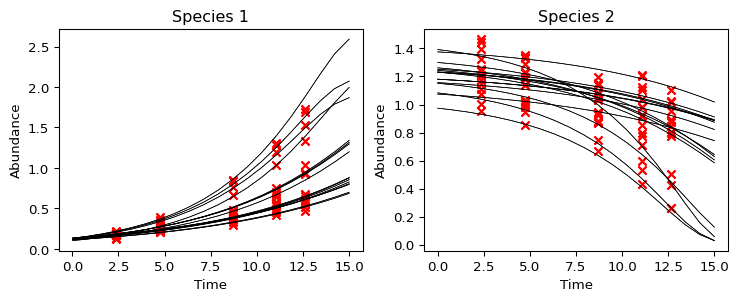

In [10]:
def plot_sim(true_abundance, fake_measurements, species_to_ax):
    f, axes = plt.subplots(1, 2, figsize=[9, 3])

    axes[species_to_ax[1]].set_title("Species 1")
    axes[species_to_ax[2]].set_title("Species 2")
    for ax in axes:
        ax.set_xlabel("Time")
        ax.set_ylabel("Abundance")
        for (tube_i, species_i), df_i in true_abundance.groupby(["tube", "species"]):
            ax = axes[species_to_ax[species_i]]
            fm = df_i.merge(
                fake_measurements.drop("time", axis=1),
                on=["tube", "species", "timepoint"]
            )
            ax.plot(
                df_i.set_index("time")["abundance"], color="black", linewidth=0.5
            )
            ax.scatter(
                fm["time"],
                fm["simulated_measurement"],
                color="r",
                marker="x",
                label="simulated measurement"
            )
    return f, axes

species_to_ax = {1: 0, 2: 1}
true_abundance = (
    idata_true.posterior["abundance"]
    .to_dataframe()
    .droplevel(["chain", "draw"])
    .join(timepoints, on="timepoint")
    .reset_index()
)
fake_measurements = measurements.join(
    idata_true.posterior_predictive["yrep"]
    .to_series()
    .droplevel(["chain", "draw"])
    .rename("simulated_measurement")
).copy()

f, axes = plot_sim(true_abundance, fake_measurements, species_to_ax)

f.savefig("monod_simulated_data.png")

# Sample in prior mode

In [11]:
stan_input_prior = stan_input_common | {
    "y": fake_measurements["simulated_measurement"],
    "likelihood": 0
}
mcmc_prior = model.sample(
    data=stan_input_prior,
    iter_warmup=100,
    iter_sampling=100,
    chains=1,
    refresh=1,
    save_warmup=True,
    inits=true_param_values,
    output_dir="results"
)
idata_prior = az.from_cmdstanpy(
    mcmc_prior,
    dims=dims,
    coords=coords,
    posterior_predictive={"y": "yrep"},
    log_likelihood="llik"
)
idata_prior

19:00:22 - cmdstanpy - INFO - CmdStan start processing

19:01:15 - cmdstanpy - INFO - CmdStan done processing.19:01:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: CVode(cvodes_mem, t_final, nv_state_, &t_init, CV_NORMAL) failed with error flag -1: 
Consider re-running with show_console=True if the above output is unclear!

arviz.InferenceData 
 
 
 
 
 
 posterior 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <xarray.Dataset>
Dimensions: (chain: 1, draw: 100, ln_mu_max_z_dim_0: 4,
 ln_ks_z_dim_0: 4, ln_gamma_z_dim_0: 4, tube: 16,
 species: 2, sigma_y_dim_0: 2, strain: 4, timepoint: 20)
Coordinates:
 * chain (chain) int64 0
 * draw (draw) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
 * ln_mu_max_z_dim_0 (ln_mu_max_z_dim_0) int64 0 1 2 3
 * ln_ks_z_dim_0 (ln_ks_z_dim_0) int64 0 1 2 3
 * ln_gamma_z_dim_0 (ln_gamma_z_dim_0) int64 0 1 2 3
 * tube (tube) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
 * species (species) int64 1 2
 * sigma_y_dim_0 (sigma_y_dim_0) int64 0 1
 * strain (strain) int64 1 2 3 4
 * timepoint (timepoint) int64 1 2 3 4 5 6 7 ... 14 15 16 17 18 19 20
Data variables: (12/15)
 ln_mu_max_z (chain, draw, ln_mu_max_z_dim_0) float64 -0.1976 ... -...
 ln_ks_z (chain, draw, ln_ks_z_dim_0) float64 -1.349 ... -0.6582
 ln_gamma_z (chain, draw, ln_gamma_z_dim_0) float64 -0.02888 ... 1...
 a_mu_max (chain, draw) float64 -1.371 -1.542 ... -1.866 -1.532
 a_ks (chain, draw) float64 -1.452 -1.341 ... -1.295 -1.284
 a_gamma (chain, draw) float64 -0.4518 -0.3613 ... -0.4556 -0.5468
 ... ...
 species_zero (chain, draw, tube, species) float64 0.09308 ... 1.17
 sigma_y (chain, draw, sigma_y_dim_0) float64 0.1022 ... 0.07151
 mu_max (chain, draw, strain) float64 0.2536 0.2548 ... 0.2159
 ks (chain, draw, strain) float64 0.2331 0.2346 ... 0.2743
 gamma (chain, draw, strain) float64 0.6364 0.6315 ... 0.5793
 abundance (chain, draw, tube, timepoint, species) float64 0.0932...
Attributes:
 created_at: 2023-02-13T18:01:15.990970
 arviz_version: 0.14.0
 inference_library: cmdstanpy
 inference_library_version: 1.1.0 xarray.Dataset Dimensions: chain : 1 draw : 100 ln_mu_max_z_dim_0 : 4 ln_ks_z_dim_0 : 4 ln_gamma_z_dim_0 : 4 tube : 16 species : 2 sigma_y_dim_0 : 2 strain : 4 timepoint : 20 Coordinates: (10) chain (chain) int64 0 array([0]) draw (draw) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99 array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]) ln_mu_max_z_dim_0 (ln_mu_max_z_dim_0) int64 0 1 2 3 array([0, 1, 2, 3]) ln_ks_z_dim_0 (ln_ks_z_dim_0) int64 0 1 2 3 array([0, 1, 2, 3]) ln_gamma_z_dim_0 (ln_gamma_z_dim_0) int64 0 1 2 3 array([0, 1, 2, 3]) tube (tube) int64 1 2 3 4 5 6 7 ... 11 12 13 14 15 16 array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]) species (species) int64 1 2 array([1, 2]) sigma_y_dim_0 (sigma_y_dim_0) int64 0 1 array([0, 1]) strain (strain) int64 1 2 3 4 array([1, 2, 3, 4]) timepoint (timepoint) int64 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
 19, 20]) Data variables: (15) ln_mu_max_z (chain, draw, ln_mu_max_z_dim_0) float64 -0.1976 0.5684 ... 1.591 -1.42 array([[[-0.19765 , 0.568366 , 1.58624 , -1.87163 ],
 [-0.0641772 , -1.61453 , -1.66266 , 0.634785 ],
 [-0.806767 , 1.14724 , -0.0634783 , -0.0149798 ],
 [-0.362942 , 0.477963 , -0.697308 , 0.224991 ],
 [ 0.280184 , 2.39382 , -0.26233 , -0.1781 ],
 [ 0.406837 , -0.533359 , 0.0373464 , 0.123059 ],
 [-0.359737 , 0.53802 , 0.0123713 , -0.128707 ],
 [ 0.628894 , -0.659708 , 0.0397204 , 0.8589 ],
 [-0.245511 , 0.330397 , -0.208105 , -0.694519 ],
 [-0.10279 , 0.543657 , 0.0449009 , -0.32595 ],
 [-1.13379 , -1.01889 , -0.327048 , 0.440668 ],
 [ 0.351432 , 0.915434 , 1.13014 , 0.729082 ],
 [-0.280347 , -0.738922 , -1.25495 , -0.81067 ],
 [ 0.895688 , -0.417731 , 0.408985 , 0.984602 ],
 [-0.698338 , 0.711453 , -0.463279 , -0.813666 ],
 [-0.622195 , 0.602835 , -0.300857 , -0.594076 ],
 [-0.105707 , 0.568127 , -0.654421 , -0.389558 ],
 [ 1.35709 , 0.452939 , 1.07563 , -0.081932 ],
 [-

We can find the prior intervals for the true abundance and plot them in
the graph.

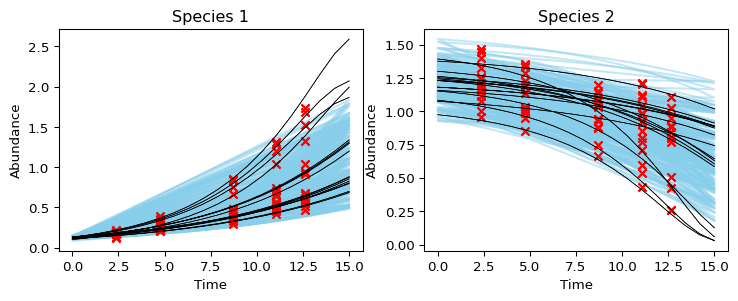

In [12]:
prior_abundances = (
    idata_prior
    .posterior["abundance"]
    .to_dataframe()
    .reset_index()
    .join(timepoints, on="timepoint")
)
n_sample = 20
chains_and_draws = (
    np.random.default_rng()
    .choice(prior_abundances[["chain", "draw"]].values, 10)
)
f, axes = plot_sim(true_abundance, fake_measurements, species_to_ax)
for tube_i in tubes:
    for species_j in species:
        abundance_sample = (
            prior_abundances.loc[
                lambda df: (df["tube"] == tube_i) & (df["species"] == species_j)
            ]
            .set_index(["chain", "draw"])
            .loc[chains_and_draws.tolist()]
            .reset_index()
        )
        axes[species_to_ax[species_j]].plot(
            abundance_sample.set_index("time")["abundance"],
            alpha=0.5, color="skyblue", zorder=-1
        )
f.savefig("monod_priors.png")

# Sample in prior + likelihood mode

In [13]:
stan_input_posterior = stan_input_common | {
    "y": fake_measurements["simulated_measurement"],
    "likelihood": 1
}
mcmc_posterior = model.sample(
    data=stan_input_posterior,
    iter_warmup=400,
    iter_sampling=400,
    chains=4,
    refresh=1,
    inits=true_param_values,
    output_dir="results"
)
idata_posterior = az.from_cmdstanpy(
    mcmc_posterior,
    dims=dims,
    coords=coords,
    posterior_predictive={"y": "yrep"},
    log_likelihood="llik"
)
idata_posterior

19:01:16 - cmdstanpy - INFO - CmdStan start processing

19:07:11 - cmdstanpy - INFO - CmdStan done processing.19:07:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: ode_bdf_tol: initial state[1] is inf, but must be finite! (in '/Users/tedgro/Documents/Writing/slides/systems_biology_for_scientific_computing/monod.stan', line 56, column 4 to line 60, column 79)
Exception: ode_bdf_tol: initial state[2] is inf, but must be finite! (in '/Users/tedgro/Documents/Writing/slides/systems_biology_for_scientific_computing/monod.stan', line 56, column 4 to line 60, column 79)
    Exception: ode_bdf_tol: ode parameters and data is inf, but must be finite! (in '/Users/tedgro/Documents/Writing/slides/systems_biology_for_scientific_computing/monod.stan', line 56, column 4 to line 60, column 79)
    Exception: lognormal_lpdf: Location parameter is nan, but must be finite! (in '/Users/tedgro/Documents/Writing/slides/systems_biology_for_scientific_computing/monod.stan', line 85, column 6 to column 64)
    Exception: lognormal_lpdf: Locati

arviz.InferenceData 
 
 
 
 
 
 posterior 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <xarray.Dataset>
Dimensions: (chain: 4, draw: 400, ln_mu_max_z_dim_0: 4,
 ln_ks_z_dim_0: 4, ln_gamma_z_dim_0: 4, tube: 16,
 species: 2, sigma_y_dim_0: 2, strain: 4, timepoint: 20)
Coordinates:
 * chain (chain) int64 0 1 2 3
 * draw (draw) int64 0 1 2 3 4 5 6 ... 394 395 396 397 398 399
 * ln_mu_max_z_dim_0 (ln_mu_max_z_dim_0) int64 0 1 2 3
 * ln_ks_z_dim_0 (ln_ks_z_dim_0) int64 0 1 2 3
 * ln_gamma_z_dim_0 (ln_gamma_z_dim_0) int64 0 1 2 3
 * tube (tube) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
 * species (species) int64 1 2
 * sigma_y_dim_0 (sigma_y_dim_0) int64 0 1
 * strain (strain) int64 1 2 3 4
 * timepoint (timepoint) int64 1 2 3 4 5 6 7 ... 14 15 16 17 18 19 20
Data variables: (12/15)
 ln_mu_max_z (chain, draw, ln_mu_max_z_dim_0) float64 -2.231 ... -1...
 ln_ks_z (chain, draw, ln_ks_z_dim_0) float64 -0.03348 ... 0.6579
 ln_gamma_z (chain, draw, ln_gamma_z_dim_0) float64 -0.1247 ... -0...
 a_mu_max (chain, draw) float64 -1.628 -1.667 ... -1.633 -1.641
 a_ks (chain, draw) float64 -1.224 -1.331 ... -1.35 -1.291
 a_gamma (chain, draw) float64 -0.4837 -0.4993 ... -0.5184 -0.5501
 ... ...
 species_zero (chain, draw, tube, species) float64 0.1066 ... 1.286
 sigma_y (chain, draw, sigma_y_dim_0) float64 0.07171 ... 0.1069
 mu_max (chain, draw, strain) float64 0.159 0.2623 ... 0.1619
 ks (chain, draw, strain) float64 0.2939 0.2937 ... 0.2761
 gamma (chain, draw, strain) float64 0.6164 0.6173 ... 0.5766
 abundance (chain, draw, tube, timepoint, species) float64 0.1068...
Attributes:
 created_at: 2023-02-13T18:07:11.637388
 arviz_version: 0.14.0
 inference_library: cmdstanpy
 inference_library_version: 1.1.0 xarray.Dataset Dimensions: chain : 4 draw : 400 ln_mu_max_z_dim_0 : 4 ln_ks_z_dim_0 : 4 ln_gamma_z_dim_0 : 4 tube : 16 species : 2 sigma_y_dim_0 : 2 strain : 4 timepoint : 20 Coordinates: (10) chain (chain) int64 0 1 2 3 array([0, 1, 2, 3]) draw (draw) int64 0 1 2 3 4 5 ... 395 396 397 398 399 array([ 0, 1, 2, ..., 397, 398, 399]) ln_mu_max_z_dim_0 (ln_mu_max_z_dim_0) int64 0 1 2 3 array([0, 1, 2, 3]) ln_ks_z_dim_0 (ln_ks_z_dim_0) int64 0 1 2 3 array([0, 1, 2, 3]) ln_gamma_z_dim_0 (ln_gamma_z_dim_0) int64 0 1 2 3 array([0, 1, 2, 3]) tube (tube) int64 1 2 3 4 5 6 7 ... 11 12 13 14 15 16 array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]) species (species) int64 1 2 array([1, 2]) sigma_y_dim_0 (sigma_y_dim_0) int64 0 1 array([0, 1]) strain (strain) int64 1 2 3 4 array([1, 2, 3, 4]) timepoint (timepoint) int64 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
 19, 20]) Data variables: (15) ln_mu_max_z (chain, draw, ln_mu_max_z_dim_0) float64 -2.231 3.055 ... 0.06912 -1.374 array([[[-2.23098 , 3.0549 , -0.211464 , -2.53953 ],
 [-2.12158 , 4.66819 , -0.0327059 , -2.74203 ],
 [-1.32786 , 4.34362 , 0.567577 , -1.79876 ],
 ...,
 [-1.42234 , 3.55784 , 0.420568 , -1.80592 ],
 [-0.635737 , 3.46172 , 0.759053 , -0.954159 ],
 [-1.75611 , 3.47649 , 0.595562 , -2.19043 ]],

 [[-2.50656 , 3.94911 , 0.0518459 , -2.10998 ],
 [-1.6764 , 4.00152 , 0.860883 , -2.04212 ],
 [-1.86976 , 3.36477 , 0.581304 , -1.75079 ],
 ...,
 [-1.73398 , 3.48353 , 0.561631 , -1.3273 ],
 [-1.77132 , 2.8886 , 0.0999953 , -2.07675 ],
 [-1.47011 , 2.45975 , -0.0927716 , -1.91639 ]],

 [[-1.82565 , 3.88333 , -0.00646839, -2.4988 ],
 [-1.99205 , 2.74006 , 0.196284 , -2.13455 ],
 [-1.49829 , 4.3448 , 1.12344 , -1.68557 ],
 ...,
 [-2.6352 , 2.37499 , -0.595892 , -2.54085 ],
 [-1.56993 , 3.66235 , 0.407074 , -2.32877 ],
 [-1.24356 , 4.28352 , 1.04123 , -1.26907 ]],

 [[-1.58322 , 2.92331 , 0.119199 , -1.67522 ],
 [-1.68922 , 4.05216 , -0.00918351, -2.81112 ],
 [-2.03857 , 3.73176 , -0.99533 , -2.75772 ],
 ...,
 [-2.01284 , 2.68787 , -0.194122 , -2.24636 ],
 [-2.02535 , 2.5339 , -0.206832 , -1.83478 ],
 [-1.14289 , 2.34324 , 0.0691169 , -1.37391 ]]]) ln_ks_z (chain, draw, ln_ks_z_dim_0) float64 -0.03348 -0.13 ... -0.5363 0.6579 a

# Diagnostics: is the posterior ok?

First check the `sample_stats` group to see if there were any divergent
transitions and if the `lp` parameter converged.

In [14]:
az.summary(idata_posterior.sample_stats)

/Users/tedgro/Documents/Writing/slides/systems_biology_for_scientific_computing/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning:

invalid value encountered in scalar divide


Next check the parameter-by-parameter summary

In [15]:
az.summary(idata_posterior)

704 rows × 9 columns

Show posterior intervals

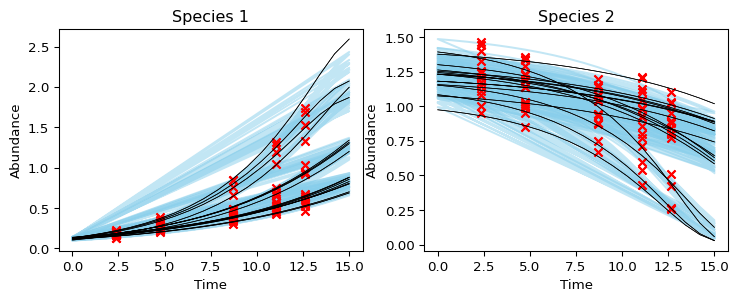

In [16]:
posterior_abundances = (
    idata_posterior
    .posterior["abundance"]
    .to_dataframe()
    .reset_index()
    .join(timepoints, on="timepoint")
)
n_sample = 20
chains_and_draws = (
    np.random.default_rng()
    .choice(posterior_abundances[["chain", "draw"]].values, 10)
)
f, axes = plot_sim(true_abundance, fake_measurements, species_to_ax)
for tube_i in tubes:
    for species_j in species:
        abundance_sample = (
            posterior_abundances.loc[
                lambda df: (df["tube"] == tube_i) & (df["species"] == species_j)
            ]
            .set_index(["chain", "draw"])
            .loc[chains_and_draws.tolist()]
            .reset_index()
        )
        axes[species_to_ax[species_j]].plot(
            abundance_sample.set_index("time")["abundance"],
            alpha=0.5, color="skyblue", zorder=-1
        )
f.savefig("monod_posteriors.png")

# look at the posterior

The next few cells use arviz’s
[`plot_posterior`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_posterior.html)
function to plot the marginal posterior distributions for some of the
model’s parameters:

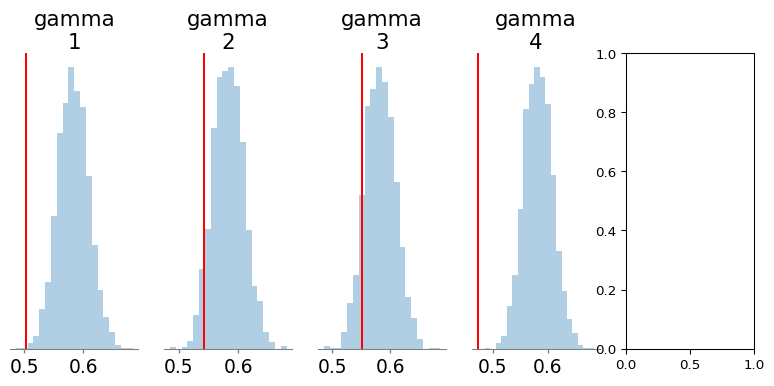

In [17]:
f, axes = plt.subplots(1, 5, figsize=[10, 4])
axes = az.plot_posterior(
    idata_posterior,
    kind="hist",
    bins=20,
    var_names=["gamma"],
    ax=axes,
    point_estimate=None,
    hdi_prob="hide"
)
for ax, true_value in zip(axes, true_param_values["gamma"]):
    ax.axvline(true_value, color="red")

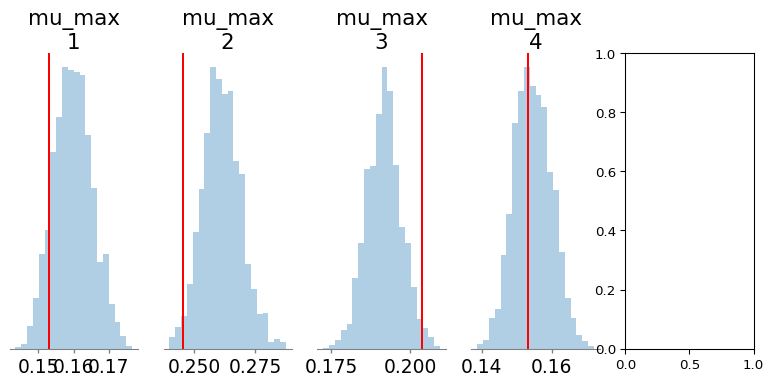

In [18]:
f, axes = plt.subplots(1, 5, figsize=[10, 4])
axes = az.plot_posterior(
    idata_posterior,
    kind="hist",
    bins=20,
    var_names=["mu_max"],
    ax=axes,
    point_estimate=None,
    hdi_prob="hide"
)
for ax, true_value in zip(axes, true_param_values["mu_max"]):
    ax.axvline(true_value, color="red")

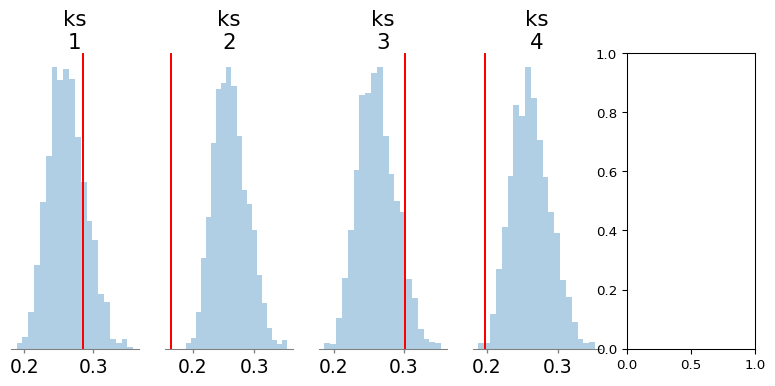

In [19]:
f, axes = plt.subplots(1, 5, figsize=[10, 4])
axes = az.plot_posterior(
    idata_posterior,
    kind="hist",
    bins=20,
    var_names=["ks"],
    ax=axes,
    point_estimate=None,
    hdi_prob="hide"
)
for ax, true_value in zip(axes, true_param_values["ks"]):
    ax.axvline(true_value, color="red")

# References

Allen, Rosalind J, and Bartłomiej Waclaw. 2019. “Bacterial Growth: A
Statistical Physicist’s Guide.” *Reports on Progress in Physics.
Physical Society (Great Britain)* 82 (1): 016601.
<https://doi.org/10.1088/1361-6633/aae546>.